# Random Forest Parameter Tuning Analysis

This notebook analyzes how different hyperparameters affect the validation accuracy of Random Forest models. Each parameter will be varied while keeping others fixed, and multiple runs with different random states will be used to obtain average performance metrics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.stats as stats
from tqdm.notebook import tqdm
from text_cluster.data_clean import get_dataframe_from_file, save_clusters_to_file, get_dataframe_from_csv

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

In [2]:
save_clusters_to_file('cleaned_data_combined.csv', 'text_cluster', cutoff=85, minimum_size=5, random_state=6)
df = get_dataframe_from_file('cleaned_data_combined.csv', 'text_cluster')

# Split the data into X (dependent variables) and t (response variable)
t = np.array(df["Label"])
X = df.drop("Label", axis=1)

# Initial data split
X_tv, X_test, t_tv, t_test = train_test_split(X, t, test_size=300/1643, random_state=0)
X_train, X_valid, t_train, t_valid = train_test_split(X_tv, t_tv, test_size=300/1343, random_state=0)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_valid.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 1043 samples
Validation set: 300 samples
Test set: 301 samples


## Utility Functions for Evaluation

In [3]:
def evaluate(model, test_features, test_labels):
    """Evaluate a model on test data and return accuracy."""
    return model.score(test_features, test_labels)

def run_multiple_trials(param_name, param_values, default_params, n_trials=10):
    """
    Run multiple trials for each parameter value and return average accuracies.
    
    Args:
        param_name: Name of the parameter to vary
        param_values: List of values to try for the parameter
        default_params: Default parameters to use for other parameters
        n_trials: Number of trials to run for each parameter value
        
    Returns:
        Dictionary with parameter values as keys and lists of trial accuracies as values
    """
    results = {val: [] for val in param_values}
    
    for param_val in tqdm(param_values, desc=f"Testing {param_name}"):
        # Create a new params dictionary with the current parameter value
        params = default_params.copy()
        params[param_name] = param_val
        
        # Run multiple trials
        for trial in range(n_trials):
            # Create random train/validation split for this trial
            X_train_trial, X_valid_trial, t_train_trial, t_valid_trial = train_test_split(
                X_tv, t_tv, test_size=300/1343, random_state=trial)
            
            # Train model with current parameters
            model = RandomForestClassifier(**params, random_state=trial, n_jobs=-1)
            model.fit(X_train_trial, t_train_trial)
            
            # Evaluate on validation set
            acc = evaluate(model, X_valid_trial, t_valid_trial)
            results[param_val].append(acc)
            
    return results

def plot_parameter_results(param_name, results, ylabel="Validation Accuracy", plot_type="line", bottom_height=0):
    """
    Plot the results of parameter tuning.
    
    Args:
        param_name: Name of the parameter varied
        results: Dictionary with parameter values as keys and lists of trial accuracies as values
        ylabel: Label for y-axis
        plot_type: Type of plot ('bar' or 'line')
    """
    # Calculate means and standard deviations
    x_values = list(results.keys())
    means = [np.mean(results[x]) * 100 for x in x_values]
    stds = [np.std(results[x]) * 100 / np.sqrt(len(results[x])) for x in x_values]
    
    # Convert x_values to strings if they contain non-numeric values
    if plot_type == "line":
        x_values_labels = ["None" if x is None else x for x in x_values]
    else:
        x_values_labels = [str(x) + '!' for x in x_values]

    # Create figure
    plt.figure(figsize=(12, 6))
    if plot_type == "bar":
        plt.bar(x_values_labels, means, yerr=stds, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
        for i, (x, y, std) in enumerate(zip(x_values_labels, means, stds)):
            plt.text(x, y + 0.5, f"{y:.2f}% ± {std:.2f}", ha='center')
        plt.ylim(bottom=bottom_height)
    elif plot_type == "line":
        # Line plot with error bars
        plt.errorbar(x_values_labels, means, yerr=stds, marker='o', linestyle='-', capsize=5, elinewidth=1, markeredgewidth=1)
        for i, (x, y, std) in enumerate(zip(x_values_labels, means, stds)):
            plt.text(x, y + 0.5, f"{y:.2f}% ± {std:.2f}", ha='center')
    
    plt.title(f"Effect of {param_name} on Random Forest Performance", fontsize=14)
    plt.xlabel(param_name, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Adjust y-axis
    ylim = plt.ylim()
    plt.ylim(ylim[0], ylim[1] + 2)
    
    plt.tight_layout()
    plt.show()
    
    # Return the best parameter value
    best_idx = np.argmax(means)
    return x_values[best_idx], means[best_idx]

## Define Parameter Grids

In [4]:
# Parameter grids
n_estimators_grid = [1, 2, 4, 10, 20, 35, 50, 75] + list(range(100, 1001, 50))
max_features_grid = list(range(1, 26, 2))
max_depth_grid = list(range(1, 52, 5))
min_samples_split_grid = list(range(2, 11))
min_samples_leaf_grid = list(range(1, 11))
bootstrap_grid = [True, False]
criterion_grid = ['gini', 'entropy']

# Default parameters to use as baseline
default_params = {
    'n_estimators': 100,
    'max_features': 'sqrt',  # Default for classification
    'max_depth': None,      # Default is None, which means nodes are expanded until all leaves are pure
    'min_samples_split': 2,  # Default
    'min_samples_leaf': 1,   # Default
    'bootstrap': True,        # Default
    'criterion': 'gini'
}

print("Parameter grids defined:")
print(f"n_estimators: {n_estimators_grid}")
print(f"max_features: {max_features_grid}")
print(f"max_depth: {max_depth_grid}")
print(f"min_samples_split: {min_samples_split_grid}")
print(f"min_samples_leaf: {min_samples_leaf_grid}")
print(f"bootstrap: {bootstrap_grid}")
print(f"criterion: {criterion_grid}")

Parameter grids defined:
n_estimators: [1, 2, 4, 10, 20, 35, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
max_features: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
max_depth: [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51]
min_samples_split: [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
bootstrap: [True, False]
criterion: ['gini', 'entropy']


## Tuning Parameters

Let's run through all parameters sequentially, optimizing one at a time.

Testing n_estimators:   0%|          | 0/27 [00:00<?, ?it/s]

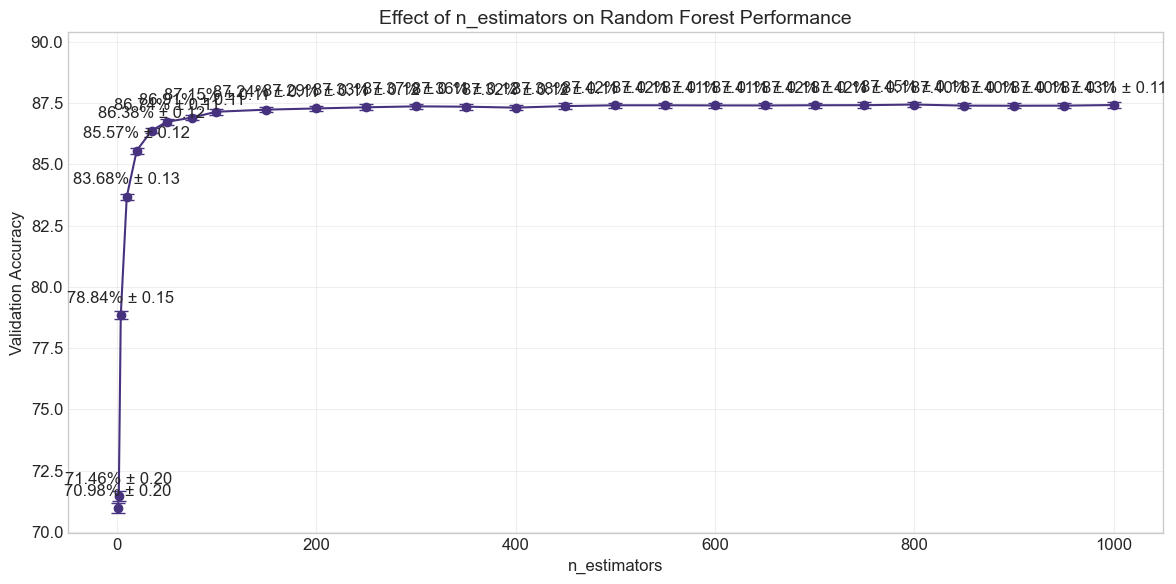

Testing max_features:   0%|          | 0/13 [00:00<?, ?it/s]

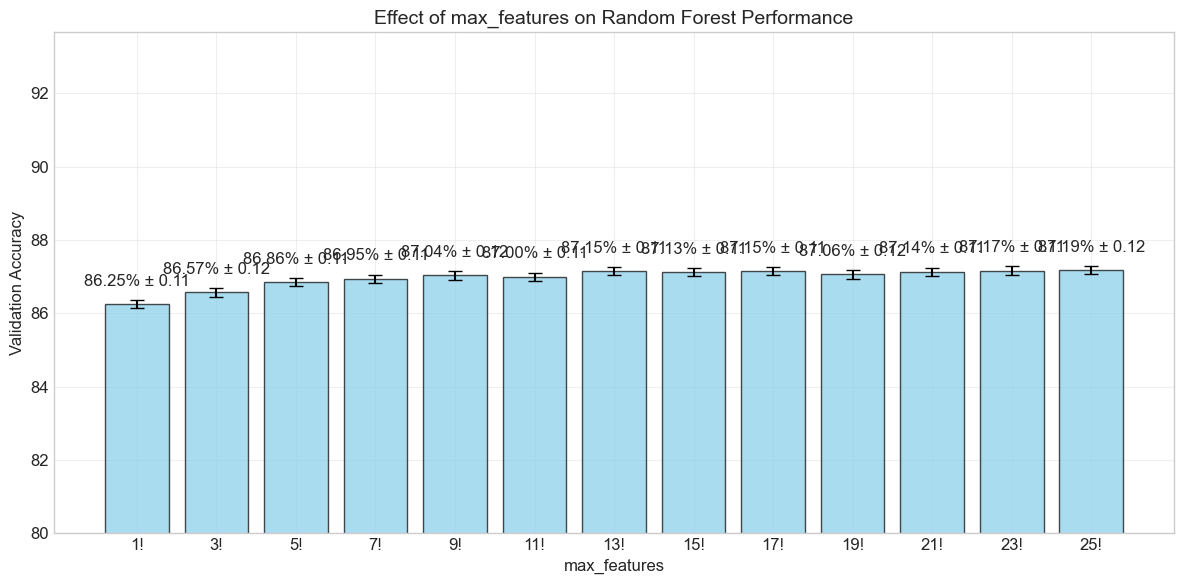

Testing max_depth:   0%|          | 0/11 [00:00<?, ?it/s]

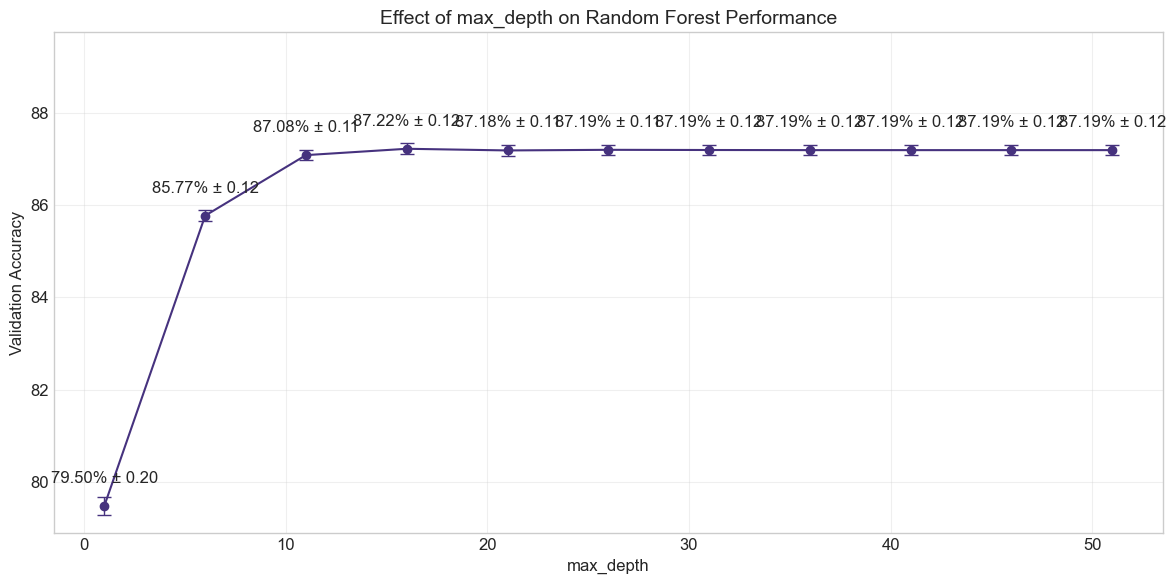

Testing min_samples_split:   0%|          | 0/9 [00:00<?, ?it/s]

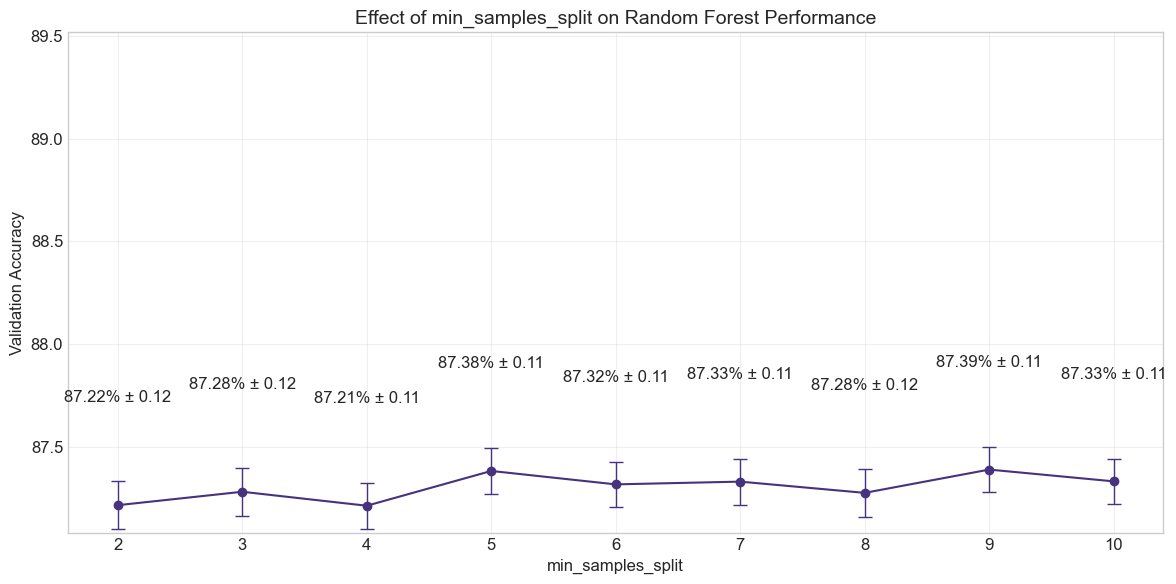

Testing min_samples_leaf:   0%|          | 0/10 [00:00<?, ?it/s]

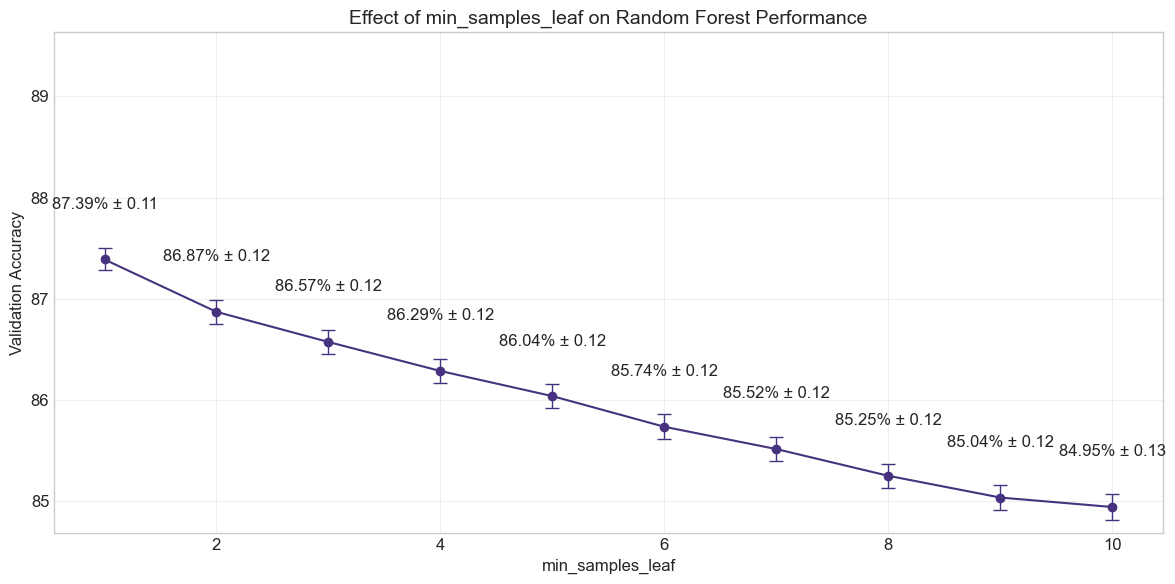

Testing bootstrap:   0%|          | 0/2 [00:00<?, ?it/s]

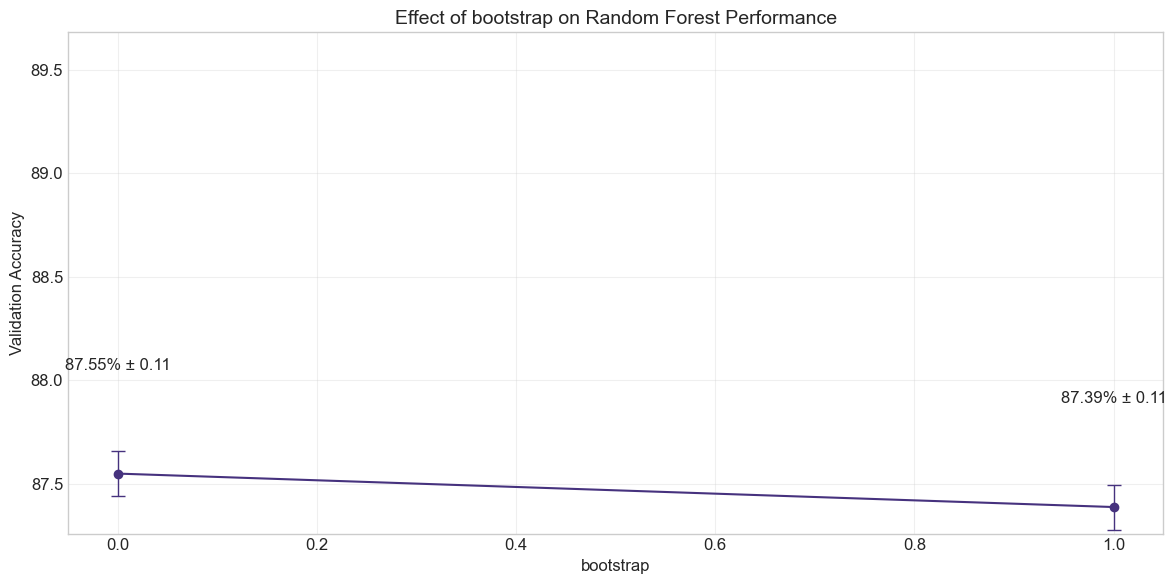

Testing criterion:   0%|          | 0/2 [00:00<?, ?it/s]

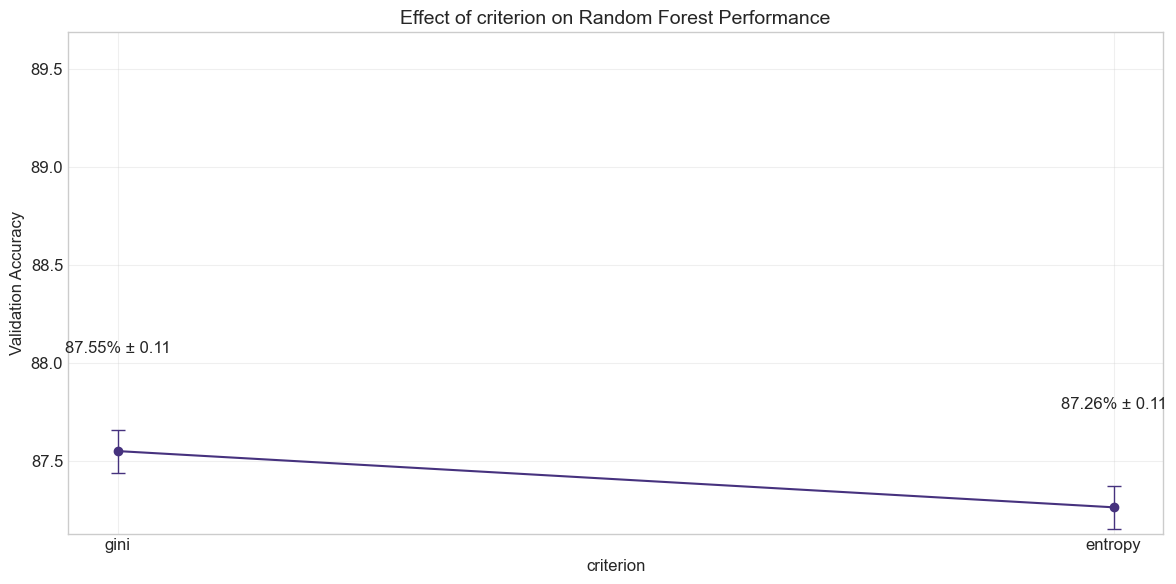

Best parameters found:
n_estimators: 800
max_features: 25
max_depth: 16
min_samples_split: 9
min_samples_leaf: 1
bootstrap: False
criterion: gini


In [ ]:
RANDOM_TESTS = 250  # Number of trials for each parameter value

# 1. Tune n_estimators
n_estimators_results = run_multiple_trials('n_estimators', n_estimators_grid, default_params, n_trials=RANDOM_TESTS)
best_n_estimators, _ = plot_parameter_results('n_estimators', n_estimators_results)
default_params['n_estimators'] = best_n_estimators
default_params['n_estimators'] = 100

# 2. Tune max_features
max_features_values = max_features_grid
max_features_results = run_multiple_trials('max_features', max_features_values, default_params, n_trials=RANDOM_TESTS)
best_max_features, _ = plot_parameter_results('max_features', max_features_results, plot_type='bar', bottom_height=80)
default_params['max_features'] = best_max_features

# 3. Tune max_depth
max_depth_values = max_depth_grid
max_depth_results = run_multiple_trials('max_depth', max_depth_values, default_params, n_trials=RANDOM_TESTS)
best_max_depth, _ = plot_parameter_results('max_depth', max_depth_results)
default_params['max_depth'] = best_max_depth

# 4. Tune min_samples_split
min_samples_split_results = run_multiple_trials('min_samples_split', min_samples_split_grid, default_params, n_trials=RANDOM_TESTS)
best_min_samples_split, _ = plot_parameter_results('min_samples_split', min_samples_split_results)
default_params['min_samples_split'] = best_min_samples_split

# 5. Tune min_samples_leaf
min_samples_leaf_results = run_multiple_trials('min_samples_leaf', min_samples_leaf_grid, default_params, n_trials=RANDOM_TESTS)
best_min_samples_leaf, _ = plot_parameter_results('min_samples_leaf', min_samples_leaf_results)
default_params['min_samples_leaf'] = best_min_samples_leaf

# 6. Tune bootstrap
bootstrap_results = run_multiple_trials('bootstrap', bootstrap_grid, default_params, n_trials=RANDOM_TESTS)
best_bootstrap, _ = plot_parameter_results('bootstrap', bootstrap_results)
default_params['bootstrap'] = best_bootstrap

# 6. Tune criterion
criterion_results = run_multiple_trials('criterion', criterion_grid, default_params, n_trials=RANDOM_TESTS)
best_criterion, _ = plot_parameter_results('criterion', criterion_results)
default_params['criterion'] = best_criterion

# Collect best parameters
best_params = {
    'n_estimators': best_n_estimators,
    'max_features': best_max_features,
    'max_depth': best_max_depth,
    'min_samples_split': best_min_samples_split,
    'min_samples_leaf': best_min_samples_leaf,
    'bootstrap': best_bootstrap,
    'criterion': best_criterion
}

print("Best parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Testing min_samples_split:   0%|          | 0/9 [00:00<?, ?it/s]

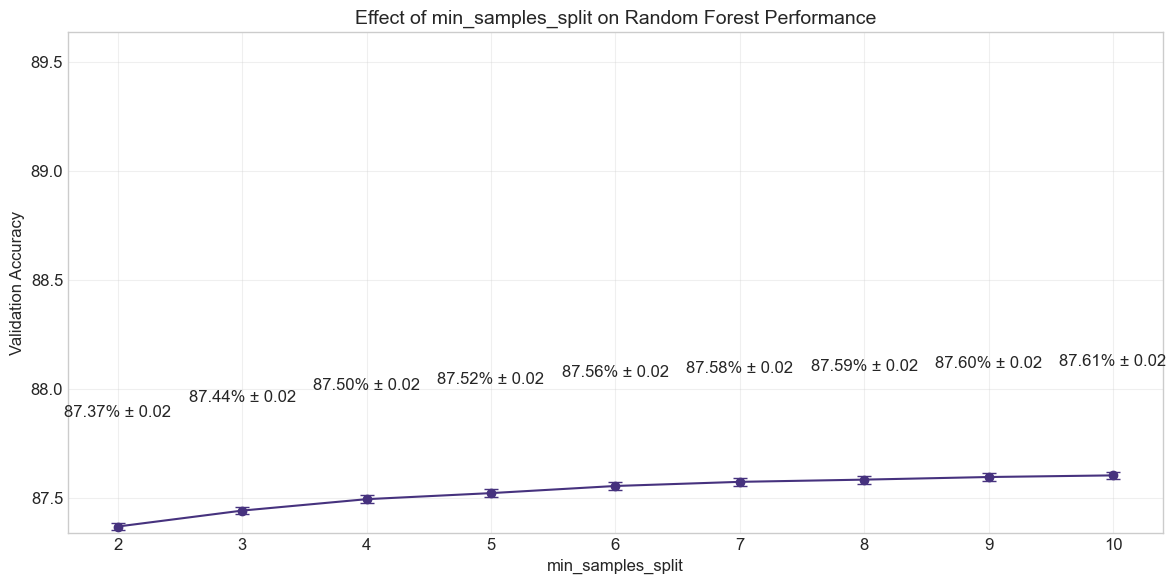

Best parameters found:
n_estimators: 250
max_features: 25
max_depth: 15
min_samples_split: 10
min_samples_leaf: 1
bootstrap: False
criterion: gini


In [167]:
RANDOM_TESTS = 10000  # Number of trials for each parameter value

best_params = {
    "n_estimators": 250,
    "max_features": 25,
    "max_depth": 15,
    "min_samples_split": 9,
    "min_samples_leaf": 1,
    "bootstrap": False,
    "criterion": 'gini'}

# 4. Tune min_samples_split
min_samples_split_results = run_multiple_trials('min_samples_split', min_samples_split_grid, best_params, n_trials=RANDOM_TESTS)
best_min_samples_split, _ = plot_parameter_results('min_samples_split', min_samples_split_results)
best_params['min_samples_split'] = best_min_samples_split

print("Best parameters found:")
for param, value in best_params.items():
    print(f"{param}: {value}")

## Compare Base Model vs. Optimized Model

In [5]:
n_trials = 25

base_accuracies = np.zeros(n_trials)
opt_accuracies = np.zeros(n_trials)

# Base model performance
for i in range(n_trials):
    base_model = RandomForestClassifier(random_state=i)
    data_train, data_valid, data_test = save_clusters_to_file('cleaned_data_combined.csv', 'text_cluster', cutoff=85, minimum_size=5, random_state=i)
    df_train, df_valid = get_dataframe_from_csv(data_train, 'text_cluster', fuzzy_cutoff=85), get_dataframe_from_csv(data_valid, 'text_cluster', fuzzy_cutoff=85)

    t_train, t_valid = np.array(df_train["Label"]), np.array(df_valid["Label"])
    X_train, X_valid = df_train.drop("Label", axis=1), df_valid.drop("Label", axis=1)
    
    base_model.fit(X_train, t_train)
    base_accuracies[i] = evaluate(base_model, X_valid, t_valid)

# Calculate base model statistics
base_acc = np.mean(base_accuracies)
base_variance = np.var(base_accuracies)
base_std = np.std(base_accuracies)

# Compute 90% confidence interval
base_ci_lower = base_acc - stats.t.ppf(0.95, df=n_trials-1) * (base_std / np.sqrt(n_trials))
base_ci_upper = base_acc + stats.t.ppf(0.95, df=n_trials-1) * (base_std / np.sqrt(n_trials))

print('Base Model Performance')
print('Validation Accuracy = {:0.2f}%'.format(base_acc*100))
print('Accuracy Variance = {:0.4f}'.format(base_variance))
print('Accuracy Standard Deviation = {:0.4f}'.format(base_std))
print('90% Confidence Interval = [{:0.2f}%, {:0.2f}%]'.format(base_ci_lower*100, base_ci_upper*100))

# Optimized model performance
best_params = {
    "n_estimators": 250,
    "max_features": 25,
    "max_depth": 15,
    "min_samples_split": 10,
    "min_samples_leaf": 1,
    "bootstrap": False
}

for i in range(n_trials):
    best_model = RandomForestClassifier(**best_params, random_state=i)
    data_train, data_valid, data_test = save_clusters_to_file('cleaned_data_combined.csv', 'text_cluster', cutoff=85, minimum_size=5, random_state=i)
    df_train, df_valid = get_dataframe_from_csv(data_train, 'text_cluster', fuzzy_cutoff=85), get_dataframe_from_csv(data_valid, 'text_cluster', fuzzy_cutoff=85)

    t_train, t_valid = np.array(df_train["Label"]), np.array(df_valid["Label"])
    X_train, X_valid = df_train.drop("Label", axis=1), df_valid.drop("Label", axis=1)

    best_model.fit(X_train, t_train)
    opt_accuracies[i] = evaluate(best_model, X_valid, t_valid)

# Calculate optimized model statistics
opt_acc = np.mean(opt_accuracies)
opt_variance = np.var(opt_accuracies)
opt_std = np.std(opt_accuracies)

# Compute 90% confidence interval
opt_ci_lower = opt_acc - stats.t.ppf(0.95, df=n_trials-1) * (opt_std / np.sqrt(n_trials))
opt_ci_upper = opt_acc + stats.t.ppf(0.95, df=n_trials-1) * (opt_std / np.sqrt(n_trials))

print('\nOptimized Model Performance')
print('Validation Accuracy = {:0.2f}%'.format(opt_acc*100))
print('Accuracy Variance = {:0.4f}'.format(opt_variance))
print('Accuracy Standard Deviation = {:0.4f}'.format(opt_std))
print('90% Confidence Interval = [{:0.2f}%, {:0.2f}%]'.format(opt_ci_lower*100, opt_ci_upper*100))

# Calculate improvement
improvement = 100 * (opt_acc - base_acc) / base_acc
print('\nImprovement of {:0.2f}%'.format(improvement))

# Statistical significance test
t_statistic, p_value = stats.ttest_ind(base_accuracies, opt_accuracies)
print('\nStatistical Significance Test')
print('T-Statistic = {:0.4f}'.format(t_statistic))
print('P-Value = {:0.4f}'.format(p_value))

Base Model Performance
Validation Accuracy = 85.45%
Accuracy Variance = 0.0006
Accuracy Standard Deviation = 0.0242
90% Confidence Interval = [84.62%, 86.28%]


KeyboardInterrupt: 

Testing Test Sizes:   0%|          | 0/20 [00:00<?, ?it/s]

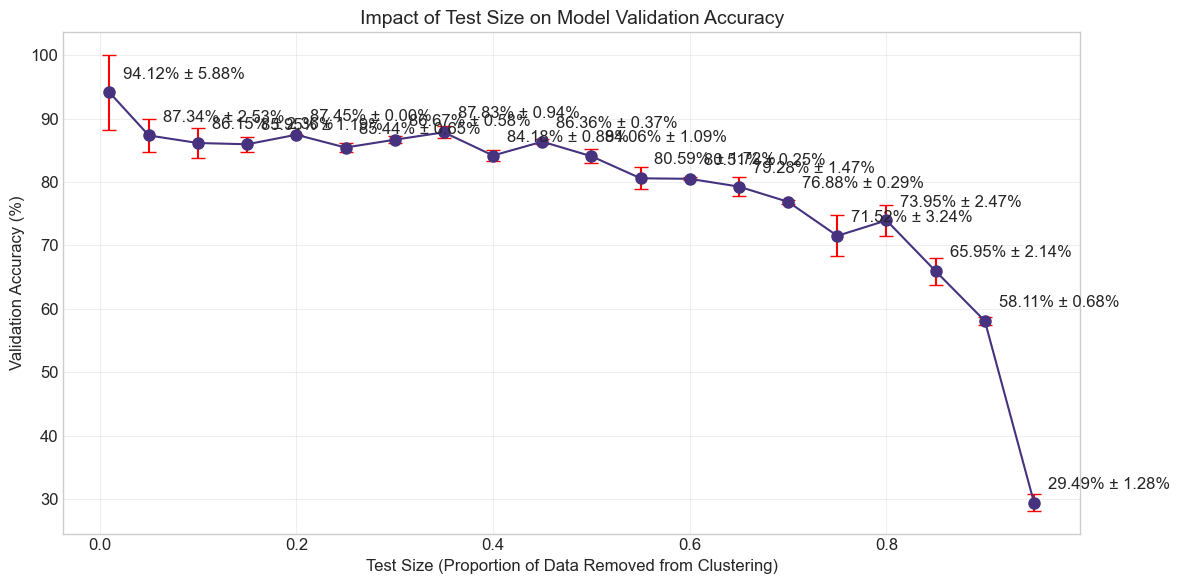


Statistical Summary:
Test Size 0.01:
  Mean Accuracy: 94.12%
  Standard Deviation: 5.88%
  95% Confidence Interval: [0.8259, 1.0565]
Test Size 0.05:
  Mean Accuracy: 87.34%
  Standard Deviation: 2.53%
  95% Confidence Interval: [0.8238, 0.9230]
Test Size 0.10:
  Mean Accuracy: 86.15%
  Standard Deviation: 2.36%
  95% Confidence Interval: [0.8151, 0.9078]
Test Size 0.15:
  Mean Accuracy: 85.95%
  Standard Deviation: 1.19%
  95% Confidence Interval: [0.8362, 0.8829]
Test Size 0.20:
  Mean Accuracy: 87.45%
  Standard Deviation: 0.00%
  95% Confidence Interval: [0.8745, 0.8745]
Test Size 0.25:
  Mean Accuracy: 85.44%
  Standard Deviation: 0.65%
  95% Confidence Interval: [0.8417, 0.8671]
Test Size 0.30:
  Mean Accuracy: 86.67%
  Standard Deviation: 0.58%
  95% Confidence Interval: [0.8553, 0.8780]
Test Size 0.35:
  Mean Accuracy: 87.83%
  Standard Deviation: 0.94%
  95% Confidence Interval: [0.8600, 0.8967]
Test Size 0.40:
  Mean Accuracy: 84.18%
  Standard Deviation: 0.89%
  95% Confiden

In [ ]:
# Function to run experiments with different test sizes
def test_size_impact(n_trials=25, test_sizes=None):
    """
    Evaluate model performance across different test sizes.
    
    Args:
        n_trials: Number of trials for each test size
        test_sizes: List of test sizes to evaluate (default: 0 to 1 in 0.1 increments)
    
    Returns:
        Dictionary of results with test sizes as keys and accuracy lists as values
    """
    # Default test sizes if not provided
    if test_sizes is None:
        test_sizes = np.linspace(0.05, 0.95, 19)  # 0 to 1 in 0.05 increments, also 0.01
        test_sizes = np.insert(test_sizes, 0, 0.01)
    
    # Best parameters from previous optimization
    best_params = {
        "n_estimators": 250,
        "max_features": 25,
        "max_depth": 15,
        "min_samples_split": 10,
        "min_samples_leaf": 1,
        "bootstrap": False
    }
    
    # Store results
    results = {test_size: [] for test_size in test_sizes}
    
    # Run trials for each test size
    for test_size in tqdm(test_sizes, desc="Testing Test Sizes"):
        for i in range(n_trials):
            # Use save_clusters_to_file with current test_size
            data_train, data_valid, data_test = save_clusters_to_file(
                'cleaned_data_combined.csv', 
                'text_cluster', 
                cutoff=85, 
                minimum_size=5, 
                random_state=i, 
                test_size=float(test_size)
            )
            
            # Get dataframes
            df_train, df_valid = (
                get_dataframe_from_csv(data_train, 'text_cluster', fuzzy_cutoff=85),
                get_dataframe_from_csv(data_valid, 'text_cluster', fuzzy_cutoff=85)
            )

            # Prepare data
            t_train, t_valid = np.array(df_train["Label"]), np.array(df_valid["Label"])
            X_train, X_valid = df_train.drop("Label", axis=1), df_valid.drop("Label", axis=1)

            # Train and evaluate model
            best_model = RandomForestClassifier(**best_params, random_state=i)
            best_model.fit(X_train, t_train)
            accuracy = evaluate(best_model, X_valid, t_valid)
            
            # Store result
            results[test_size].append(accuracy)
    
    return results

# Plot results
def plot_test_size_impact(results):
    """
    Create a visualization of test size impact on validation accuracy.
    
    Args:
        results: Dictionary of results from test_size_impact function
    """
    # Calculate means and standard errors
    test_sizes = list(results.keys())
    means = [np.mean(results[size]) * 100 for size in test_sizes]
    stds = [stats.sem(results[size]) * 100 for size in test_sizes]
    
    # Create plot
    plt.figure(figsize=(12, 6))
    plt.errorbar(test_sizes, means, yerr=stds, 
                 marker='o', linestyle='-', capsize=5, 
                 ecolor='red', markersize=8, 
                 label='Validation Accuracy')
    
    # Annotate points
    for x, y, std in zip(test_sizes, means, stds):
        plt.annotate(f'{y:.2f}% ± {std:.2f}%', 
                     (x, y), 
                     xytext=(10, 10), 
                     textcoords='offset points')
    
    plt.title('Impact of Test Size on Model Validation Accuracy', fontsize=14)
    plt.xlabel('Test Size (Proportion of Data Removed from Clustering)', fontsize=12)
    plt.ylabel('Validation Accuracy (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return test_sizes, means

# Run the experiment
results = test_size_impact(n_trials=25)
test_sizes, accuracies = plot_test_size_impact(results)

# Perform statistical analysis
print("\nStatistical Summary:")
for size, acc_list in results.items():
    print(f"Test Size {size:.2f}:")
    print(f"  Mean Accuracy: {np.mean(acc_list)*100:.2f}%")
    print(f"  Standard Deviation: {np.std(acc_list)*100:.2f}%")
    print(f"  95% Confidence Interval: [{np.mean(acc_list)-1.96*stats.sem(acc_list):.4f}, {np.mean(acc_list)+1.96*stats.sem(acc_list):.4f}]")